# Building Footprints

In [14]:
import scipy.stats as stats
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
import os
import warnings
import geopandas as gpd
import shapely
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
import json
from shapely.geometry import Polygon
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from PIL import ImageColor, Image
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import pyproj
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
import rasterstats as rs
from joblib import Parallel, delayed
import multiprocessing
import xarray as xr

fp=pd.DataFrame()
gr=pd.DataFrame()
pt=pd.DataFrame()

#dir='../data/GEE/'
#dir='../data/GEE_1_month/'

dir='../data/Gaza/'
for file in os.listdir(dir):
    if 'csv' in file:
        try:
            tdf=pd.read_csv(dir+file)
            tdf['loc']=file.split('_')[0]
            tdf['date']=pd.to_datetime(file.split('_')[1])
            if "Gaza" in dir:
                tdf['loc']=tdf['loc']+' '+tdf['date'].dt.strftime('%Y-%m-%d')
            tdf['period']=int(file.split('_')[2])
            if 'grid' in file:
                gr=pd.concat([gr,tdf])
            elif 'footprint' in file:
                fp=pd.concat([fp,tdf])
        except:
            pt=pd.concat([pt,tdf])

def convert_ticks(sub, ax, crs='epsg:4326'):
    x_ticks=ax.get_xticks()
    y_ticks=ax.get_yticks()
    inProj = pyproj.Proj(init=sub.crs.to_string())
    outProj = pyproj.Proj(init=crs)
    xticks, _ = pyproj.transform(inProj,outProj,x_ticks,[0]*len(x_ticks))
    _, yticks = pyproj.transform(inProj,outProj,[0]*len(y_ticks),y_ticks)
    xticks=[round(x, 2) for x in xticks]
    yticks=[round(y, 2) for y in yticks]
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)

mapbox_token='pk.eyJ1Ijoib2JhbGxpbmdlciIsImEiOiJjazdvbXFkMWEwYXVrM2ZtdHU0cTd0cG5hIn0.vIj9s8F6M49ZP5DAh9Kd3Q'
px.set_mapbox_access_token('pk.eyJ1Ijoib2JhbGxpbmdlciIsImEiOiJjazdvbXFkMWEwYXVrM2ZtdHU0cTd0cG5hIn0.vIj9s8F6M49ZP5DAh9Kd3Q')

fp['geometry']=fp['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
fp = gpd.GeoDataFrame(fp, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)
# drop daraa
fp=fp[fp['loc']!='Daraa']

def add_country_names(df, loc_to_country):
    df['country'] = df['loc'].map(loc_to_country).fillna('Ukraine')
    return df
loc_to_country = {
    'Aleppo': 'Syria',
    'Mosul': 'Iraq',
    'Raqqa': 'Syria',
    'Gaza': 'Palestine',
}

fp['country']=fp['loc'].map(loc_to_country).fillna('Ukraine')
fp['loc_count']=fp.groupby('loc')['loc'].transform('count')
fp.reset_index(inplace=True)
fp=fp.rename(columns={'index':'fp_id'})
fp['fp_id']=fp['loc']+'_'+fp['fp_id'].astype(str)
fp.reset_index(inplace=True)

gr['geometry']=gr['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
gr = gpd.GeoDataFrame(gr, geometry='geometry', crs="EPSG:3857")


gr['country']=gr['loc'].map(loc_to_country).fillna('Ukraine')
gr['loc_count']=gr.groupby('loc')['loc'].transform('count')
gr.reset_index(inplace=True)
gr=gr.rename(columns={'index':'grid_id'})
gr['grid_id']=gr['loc']+'_'+gr['grid_id'].astype(str)
gr.reset_index(inplace=True)

gr=gr.rename(columns={'index':'grid_index'})
gr_geosubset=gr[['geometry','grid_id','grid_index']].drop_duplicates(subset='geometry')
fp=gpd.sjoin(fp, gr_geosubset, how='left').fillna(0)

bct=fp.groupby('grid_id')['class'].count().rename('b_count')
dbct=fp.groupby('grid_id')['class'].sum().rename('db_count')

fp['area_t']=fp['k50']*fp['area']
dbt=fp.groupby('grid_id')['area_t'].mean().rename('db_mean_t')
gr=gr.merge(bct, how='left', on='grid_id')
gr=gr.merge(dbct, how='left', on='grid_id')
gr=gr.merge(dbt, how='left', on='grid_id')
gr['db_pct']=gr['db_count']/gr['b_count']
gr['area']=2500
fp.sort_values(by=['date','country','loc_count'], inplace=True, ascending=False)
gr.sort_values(by=['date','country','loc_count'], inplace=True, ascending=False)

fp=fp[fp['loc']!='NorthKharkiv']
gr=gr[gr['loc']!='NorthKharkiv']

In [ ]:
def get_coh(loc, cfp, cgr):
    if loc=='NorthKharkiv':
        loc1='Kharkiv'
    else:
        loc1=loc
    files=[x for x in os.listdir(clean_dir) if loc1 in x]
    rasters=[]
    print(loc)
    for file in files:
        ds=xr.open_dataset(clean_dir+file, engine='rasterio', mask_and_scale=True)
        if np.isnan(ds.band_data[0]).any():
            pass
        else:
            rasters.append(ds)
    try:
        raster=(rasters[0]+rasters[1])/2
    except:
        raster=rasters[0]

    raster.band_data[0].plot(vmin=-.50, vmax=0)

    sub=fp.to_crs(raster.rio.crs)
    sub=sub[sub['loc']==loc]

    sub['coh_change']=sub.apply(lambda x: raster.sel(x=x['geometry'].centroid.x, y=x['geometry'].centroid.y, method='nearest').band_data.values[0], axis=1)*-1
    sub['coh_pre']=sub.apply(lambda x: raster.sel(x=x['geometry'].centroid.x, y=x['geometry'].centroid.y, method='nearest').band_data.values[1], axis=1)
    sub['coherence']=sub['coh_change']*sub['coh_pre']

    sub=sub.to_crs(fp.crs)

    sub_g=gr.to_crs(raster.rio.crs)
    sub_g=sub_g[sub_g['loc']==loc]
    colnames=['coh_change','coh_pre']

    for i in range(0,2):
        array=raster.band_data.values[i]
        rasterstats = rs.zonal_stats(sub_g, array, affine=raster.rio.transform(), stats=['mean'], nodata=np.NaN)
        sub_g[colnames[i]]=list(pd.DataFrame(rasterstats)['mean'])
    
    sub_g['coh_change']=sub_g['coh_change']*-1
    sub_g['coherence']=sub_g['coh_change']*sub_g['coh_pre']

    sub_g=sub_g.to_crs(gr.crs)

    cgr=pd.concat([cgr, sub_g])
    cfp=pd.concat([cfp, sub])

    #auc_test('coherence')
    #auc_test('k50')
    #auc_test('combined')
    return cfp, cgr


clean_dir='../data/insar/clean/'
cfp=pd.DataFrame()
cgr=pd.DataFrame()

locs=fp['loc'].unique()

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(get_coh)(loc, cfp, cgr) for loc in locs)

cfp=pd.concat([x[0] for x in results])
cgr=pd.concat([x[1] for x in results])

python(53667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Gaza
Lysychansk
Sievierodonetsk
Rubizhne
Kharkiv
Mariupol
Irpin
Hostomel
Chernihiv
Raqqa


KeyboardInterrupt: 

In [ ]:
grouped=fp.groupby('loc').agg({'country':'first','fp_id':'count','class':'mean', 'date':'first'}).reset_index()
grouped['class']=(grouped['class']*100).round(2)
grouped.rename(columns={'fp_id':'Footprints', 'loc':'City','country':'Country','date':'Annotations Date','class':'\% Damaged'}, inplace=True)
grouped=grouped.set_index('Country')
grouped.reset_index(inplace=True)
grouped.sort_values(by='Annotations Date', inplace=True, ascending=False)
grouped=grouped.astype(str)
total_row=pd.DataFrame({'Footprints':len(fp),'City':' ','Country':'Total','Annotations Date':' ','\% Damaged':(fp['class'].mean()*100).round(2).astype(str)}, index=[0])

#grouped=pd.concat([grouped, total_row])

print(grouped.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
  Country &            City & Footprints & \textbackslash \% Damaged & Annotations Date \\
\midrule
Palestine &            Gaza &     220160 &      57.21 &       2024-05-03 \\
  Ukraine &      Lysychansk &      22280 &       7.77 &       2022-09-21 \\
  Ukraine & Sievierodonetsk &       7085 &      25.43 &       2022-07-27 \\
  Ukraine &        Rubizhne &       9905 &      33.81 &       2022-07-09 \\
  Ukraine &         Kharkiv &     122590 &       0.91 &       2022-06-15 \\
  Ukraine &        Mariupol &      20481 &      32.57 &       2022-05-12 \\
  Ukraine &        Hostomel &       4728 &      14.11 &       2022-03-31 \\
  Ukraine &           Irpin &       7917 &      11.56 &       2022-03-31 \\
  Ukraine &       Chernihiv &      33733 &       3.36 &       2022-03-22 \\
    Syria &           Raqqa &      26728 &      45.78 &       2017-10-21 \\
     Iraq &           Mosul &     151259 &      11.59 &       2017-08-04 \\
    Syria &          Aleppo &   

In [ ]:
len(fp[fp['area']<100])/len(fp)

0.22549617810805725

In [ ]:
# pct of buildings by country 
fp.groupby('loc')['class'].count()/fp['class'].count()

loc
Aleppo             0.105116
Chernihiv          0.048156
Gaza               0.314290
Hostomel           0.006749
Irpin              0.011302
Kharkiv            0.175004
Lysychansk         0.031806
Mariupol           0.029238
Mosul              0.215930
Raqqa              0.038156
Rubizhne           0.014140
Sievierodonetsk    0.010114
Name: class, dtype: float64

In [15]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

def scale_features(data, cols):
    scaler = StandardScaler()
    scaler.fit(data[cols])
    X = scaler.transform(data[cols])
    for col in cols:
        data[col] = X[:, cols.index(col)]
    return data

def scale_dataframe(df, cols):
    cities=df['loc'].unique()
    scaled_df=pd.DataFrame()
    for city in cities:
        sub=df[df['loc']==city]
        X = scale_features(sub, cols)
        scaled=pd.DataFrame(X, columns=cols)
        scaled['loc']=city
        scaled['class']=sub['class'].values
        scaled_df=pd.concat([scaled_df, scaled])
    return scaled_df

def inference(sub, cols, mode='prc'):
    #var = 'pc'
    #X = scale_features(sub, cols)
    #sub['pc'] = PCA(n_components=1).fit_transform(X[cols])
    X = sub[cols]
    var=cols[0]
    if mode == 'kmeans':
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
        y_pred = 1 - kmeans.labels_ if sum(kmeans.labels_ == 1) > sum(kmeans.labels_ == 0) else kmeans.labels_
    elif mode == 'prc':
        precision, recall, thresholds = precision_recall_curve(sub['class'], sub[var], sample_weight=sub['area'])
        f1=(2 * (precision * recall) / (precision + recall))
        f1=f1[~np.isnan(f1)]
        ix = np.argmax(f1)
        cutoff = thresholds[ix]
        y_pred = np.where(sub[var] > cutoff, 1, 0)
    elif mode == 'xgb':
        model = xgb.XGBClassifier()
        model.fit(X, sub['class'])
        y_pred = model.predict(X)

    sub['pred'] = y_pred
    
    metrics = calculate_metrics(sub['class'], sub['pred'], sub['area'])
    print_metrics(metrics)

    sub['val'] = np.where((sub['pred'] == 1) & (sub['class'] == 1), 'TP', 'TN')  # true positive
    sub['val'] = np.where((sub['pred'] == 1) & (sub['class'] == 0), 'FP', sub['val'])  # false positive
    sub['val'] = np.where((sub['pred'] == 0) & (sub['class'] == 1), 'FN', sub['val'])  # false negative

    sub.sort_values(by='val', ascending=True, inplace=True)
    return sub

def calculate_metrics(y_true, y_pred, area):
    acc = accuracy_score(y_true, y_pred, sample_weight=area)
    f1 = f1_score(y_true, y_pred, sample_weight=area)
    prec = precision_score(y_true, y_pred, sample_weight=area)
    rec = recall_score(y_true, y_pred, sample_weight=area)
    return np.array([acc, f1, prec, rec])

def print_metrics(metrics):
    print('Accuracy:', metrics[0])
    print('F1:', metrics[1])
    print('Precision:', metrics[2])
    print('Recall:', metrics[3])


def run_ML(sub, cols, model='xgb', cutoff=3):
    metrics=np.array([])
    #sub['combined'] = PCA(n_components=1).fit_transform(sub[cols])
    area=sub['area']
    fpr, tpr, thresholds = roc_curve(sub['class'], sub[cols],sample_weight=area)
    roc_auc = auc(fpr, tpr)
    #area=np.log(1+sub['area'])
    #area=(area-area.min())/(area.max()-area.min())
    #area=area.fillna(1)
    #area=1**area
    if model == 'kmeans':
        cluster = KMeans(n_clusters=2, random_state=0).fit(sub[cols])
        y_pred = 1 - cluster.labels_ if sum(cluster.labels_ == 1) > sum(cluster.labels_ == 0) else cluster.labels_
        m=calculate_metrics(sub['class'], y_pred, area)
        metrics=np.append(metrics, m)

    elif model == 'prc':
        precision, recall, thresholds = precision_recall_curve(sub['class'], sub[cols], sample_weight=area)
        f1=(2 * (precision * recall) / (precision + recall))
        f1=f1[~np.isnan(f1)]
        ix = np.argmax(f1)
        threshold = thresholds[ix]        
        y_pred = np.where(sub[cols] > threshold, 1, 0)
        m=calculate_metrics(sub['class'], y_pred, area)
        metrics=np.append(metrics, m)
    elif model == 'gmm':
        gmm = GaussianMixture(n_components=2, random_state=0).fit(sub[cols])
        y_pred = 1 - gmm.predict(sub[cols]) if sum(gmm.predict(sub[cols]) == 1) > sum(gmm.predict(sub[cols]) == 0) else gmm.predict(sub[cols])
        m=calculate_metrics(sub['class'], y_pred)
        metrics=np.append(metrics, m)

    elif model == 'xgb' or model == 'mlp':
        kf = KFold(n_splits=10, shuffle=True, random_state=0)
        for train_index, test_index in kf.split(sub):
        #kf = GroupShuffleSplit(n_splits=10, random_state=0)
        #for train_index, test_index in kf.split(sub, groups=sub['grid_index']):
            X_train, X_test = sub.iloc[train_index][cols], sub.iloc[test_index][cols]
            y_train, y_test = sub.iloc[train_index]['class'], sub.iloc[test_index]['class']
            area=sub.iloc[test_index]['area']*0+1
            #area=(area-area.min())/(area.max()-area.min())
            if model == 'xgb':
                model = xgb.XGBClassifier()
            elif model == 'mlp':
                model = MLPClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            m=calculate_metrics(y_test, y_pred, area)
            metrics=np.append(metrics, m)
    elif model=='cutoff':
        #sub['combined'] = PCA(n_components=1).fit_transform(X)
        #fpr, tpr, thresholds = roc_curve(sub['class'], sub['combined'])
        #roc_auc = auc(fpr, tpr)
        #optimal_idx = np.argmax(tpr - fpr)
        y_pred = np.where(sub[cols] > cutoff, 1, 0)
        m=calculate_metrics(sub['class'], y_pred, area)
        metrics=np.append(metrics, m)
    
    metrics=np.mean(metrics.reshape(-1, 4), axis=0)
    metrics=np.append(metrics, roc_auc)
    return metrics


def make_table(df, cols, model='prc', balance=False, holdout=False, geo_level='loc'):

    #df=scale_dataframe(df, cols)
    results = pd.DataFrame()

    cities=df[geo_level].unique()
    if holdout: 
        for test_city in cities:
            test=df[df['loc']==test_city]
            train=df[~df['loc'].isin([test_city])]
            X_train, X_test, y_train, y_test = train[cols], test[cols], train['class'], test['class']
            model = xgb.XGBClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            res=calculate_metrics(y_test, y_pred)
            row=pd.DataFrame({'Location': test_city, 'Accuracy': res[0],'AUC':0, 'F1': res[1], 'Precision': res[2], 'Recall': res[3],'N': len(test)}, index=[0])
            results = pd.concat([results, row])
    else:
        for loc in cities:
            sub = df[df[geo_level] == loc]
            if balance:
                sub = pd.concat([sub[sub['class'] == 1], sub[sub['class'] == 0].sample(n=len(sub[sub['class'] == 1]), replace=True)])
            res = run_ML(sub, cols, model) 
            row = pd.DataFrame({'Location': loc, 'AUC':res[4],'Accuracy': res[0], 'F1': res[1], 'Precision': res[2], 'Recall': res[3],'N': len(sub)}, index=[0])
            results = pd.concat([results, row])
    if balance:
        all_data = pd.concat([df[df['class'] == 1], df[df['class'] == 0].sample(n=len(df[df['class'] == 1]))])
    else:
        all_data = df
    all_res = run_ML(all_data, cols, model)
    all_row = pd.DataFrame({'Location': 'All', 'AUC':all_res[4], 'Accuracy': all_res[0], 'F1': all_res[1], 'Precision': all_res[2], 'Recall': all_res[3], 'N': len(all_data)}, index=[0])
    avg = np.average(results[['AUC','Accuracy', 'F1', 'Precision', 'Recall']], weights=results['N'], axis=0, returned=True)
    avg_row = pd.DataFrame({'Location': 'Average', 'AUC': avg[0][1],'Accuracy': avg[0][0],  'F1': avg[0][2], 'Precision': avg[0][3], 'Recall': avg[0][4], 'N': len(df)}, index=[0])
    results = pd.concat([results,all_row]).round(2)
    return results

def compare_results(results1, results2):
    acc_cols = ['Accuracy', 'F1', 'Precision', 'Recall']
    diff=pd.DataFrame()
    diff['Location']=results1['Location']
    for col in acc_cols:
        diff[col] = results1[col] - results2[col]
    diff['N'] = results1['N']
    return diff

hot_locs=fp.columns[fp.columns.str.contains('loc_')]
hot_country=fp.columns[fp.columns.str.contains('country_')]
#add country and loc cols 

amp = ['max_change', 'k20', 'k50', 'k100', 'k150'] 
opt = ['B2', 'B3', 'B4', 'B8', 'B12']
coh = ['coh_change','coherence','coh_pre']
aux=  ['area','grid_index']
all=amp+opt+coh+aux
    
#tdf=cfp[(cfp['loc']!='Kharkiv')&(cfp['area']>100)]
#tdf=cfp[(cfp['loc']!='Kharkiv')]

fp['combined']=fp[['max_change','k50','k100','k150']].mean(axis=1)

gr['combined']=gr[['max_change','k50','k100']].mean(axis=1)
res=make_table(fp, ['combined'], model='prc', geo_level='loc')
res=res[['Location','AUC','F1','Precision','Recall']]
print(res.astype(str).to_latex(index=False))
res

\begin{tabular}{lllll}
\toprule
       Location &  AUC &   F1 & Precision & Recall \\
\midrule
Gaza 2024-05-03 & 0.84 & 0.79 &      0.71 &   0.89 \\
Gaza 2024-04-01 & 0.85 & 0.78 &       0.7 &   0.89 \\
Gaza 2024-02-29 & 0.85 & 0.78 &      0.71 &   0.88 \\
Gaza 2024-01-07 & 0.83 & 0.66 &      0.56 &    0.8 \\
Gaza 2023-11-26 & 0.85 & 0.56 &      0.47 &    0.7 \\
Gaza 2023-11-07 & 0.84 & 0.49 &      0.42 &   0.57 \\
            All & 0.86 & 0.72 &      0.64 &   0.81 \\
\bottomrule
\end{tabular}



,Location,AUC,F1,Precision,Recall
0,Gaza 2024-05-03,0.84,0.79,0.71,0.89
0,Gaza 2024-04-01,0.85,0.78,0.70,0.89
0,Gaza 2024-02-29,0.85,0.78,0.71,0.88
0,Gaza 2024-01-07,0.83,0.66,0.56,0.80
0,Gaza 2023-11-26,0.85,0.56,0.47,0.70
0,Gaza 2023-11-07,0.84,0.49,0.42,0.57
0,All,0.86,0.72,0.64,0.81


In [ ]:
res

,Location,AUC,F1,Precision,Recall,N
0,Gaza,0.84,0.79,0.71,0.89,220160
0,Lysychansk,0.79,0.55,0.54,0.56,22280
0,Sievierodonetsk,0.71,0.66,0.54,0.84,7085
0,Rubizhne,0.79,0.69,0.67,0.71,9905
0,Kharkiv,0.81,0.30,0.28,0.32,122590
0,Mariupol,0.72,0.72,0.60,0.90,20481
0,Irpin,0.85,0.61,0.53,0.71,7917
0,Hostomel,0.85,0.73,0.66,0.81,4728
0,Chernihiv,0.88,0.52,0.39,0.78,33733
0,Raqqa,0.77,0.76,0.68,0.86,26728


In [ ]:
cols = ['max_change', 'VV', 'VH', 'k20', 'k50', 'k100', 'k150', 'B2', 'B3', 'B4', 'B8', 'B12','coh_change','coherence','coh_pre']
gr['class']=gr['db_count'].apply(lambda x: 1 if x>10 else 0)
make_table(cgr[~cgr['loc'].isin(['Daara'])], cols, model='xgb', holdout=False, balance=False)


In [ ]:
filename='Raqqa_20171021_2_grid_32'
#filename='Aleppo_20160918_2_grid_32'
gr32=pd.read_csv(f'../data/{filename}.csv')
gr32.value_counts('class', normalize=True)
gr32['geometry']=gr32['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
gr32 = gpd.GeoDataFrame(gr32, geometry='geometry', crs="EPSG:3857")
gr32['loc']=filename.split('_')[0]

In [ ]:
gr32['area']=32*32
gr32=gr32.fillna(0)
res=make_table(gr32, ['k50'], model='prc', geo_level='loc')
res=res[['Location','AUC','F1','Precision','Recall','N']]
res

,Location,AUC,F1,Precision,Recall,N
0,Aleppo,0.74,0.3,0.21,0.54,226805
0,All,0.74,0.3,0.21,0.54,226805


In [ ]:
from itertools import combinations

def run_ML_cross(df, cols, balance):
    cities=df['loc'].unique()
    df.sort_values(by='country', inplace=True)
    df=scale_dataframe(df, cols)

    results=pd.DataFrame()
    for train_city in cities:
        for test_city in cities:
            train=df[df['loc']==train_city]
            test=df[df['loc']==test_city]
            if balance: 
                train = pd.concat([train[train['class'] == 1], train[train['class'] == 0].sample(n=len(train[train['class'] == 1]), replace=True)])
                test=pd.concat([test[test['class'] == 1], test[test['class'] == 0].sample(n=len(test[test['class'] == 1]), replace=True)])
            else:
                pass
            if train_city==test_city:
                X_train, X_test, y_train, y_test = train_test_split(train[cols], train['class'], test_size=0.2, random_state=1)
            else:
                X_train, X_test, y_train, y_test = train[cols], test[cols], train['class'], test['class']
            model = xgb.XGBClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1= f1_score(y_test, y_pred)
            row=pd.DataFrame({'Test':test_city, 'F1':f1}, index=[train_city])
            results=pd.concat([results,row])
    heatmap=results.pivot( columns="Test", values="F1").round(2)
    sns.heatmap(heatmap, annot=True, cmap='coolwarm', center=0.5,vmin=0, vmax=1)
    plt.show()
    return results

results=run_ML_cross(cfp, cols, balance=True)


In [ ]:
heatmap=results.pivot( columns="Test", values="F1").round(2)
sns.heatmap(heatmap, annot=True, cmap='viridis', vmin=0.5, vmax=1)
#heatmap

In [ ]:
# plot pca 
from sklearn.decomposition import PCA

def plot_pca(df, cols, n_components=2):
    #scale the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df[cols])
    X=scaler.transform(df[cols]) 

    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_pca=pca.transform(X)
    print(X_pca)
    #plot
    df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
    df_pca['class']=df['class'].values
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='PC1', y='PC2', hue='class', data=df_pca, ax=ax, palette='Set1')

def plot_umap(df, cols, n_components=2):
    import umap
    reducer = umap.UMAP(n_components=n_components)
    embedding = reducer.fit_transform(df[cols])
    df_umap=pd.DataFrame(embedding, columns=['PC1','PC2'])
    df_umap['class']=df['class'].values
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='PC1', y='PC2', hue='class', data=df_umap, ax=ax, palette='Set1')

#df_pca=plot_pca(fp[fp['loc']=='Irpin'].dropna(), cols, n_components=1)
cols=['max_change','VV','VH','k20','k50','k100','k150', 'B2','B3','B4','B8','B12', 'contrast', 'correlation','diff_variance','sum_variance','sum_average', 'variance']
#plot_umap(fp[fp['loc']=='Mariupol'].dropna(), cols, n_components=2)

# Single-Variable cutoff tuning 

In [ ]:
fp['loc'].unique()

array(['Lysychansk', 'Sievierodonetsk', 'Rubizhne', 'Kharkiv', 'Mariupol',
       'Hostomel', 'Chernihiv'], dtype=object)

['red', '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600', 'green', 'blue', 'olive']
Palestine 2 0.55 0.99
Palestine 3 0.75 0.78
Palestine 4 0.83 0.39
Palestine 5 0.86 0.2
Palestine 6 0.88 0.11
Palestine 7 0.9 0.07
Ukraine 2 0.23 0.9
Ukraine 3 0.48 0.59
Ukraine 4 0.63 0.35
Ukraine 5 0.7 0.24
Ukraine 6 0.69 0.16
Ukraine 7 0.7 0.13
Syria 2 0.43 0.99
Syria 3 0.65 0.44
Syria 4 0.75 0.1
Syria 5 0.79 0.03
Syria 6 0.82 0.01
Syria 7 0.81 0.0
Iraq 2 0.14 0.99
Iraq 3 0.23 0.75
Iraq 4 0.4 0.42
Iraq 5 0.51 0.24
Iraq 6 0.58 0.15
Iraq 7 0.62 0.1
Average AP:  0.5860593769524416
Average AUC:  0.8070007250054665


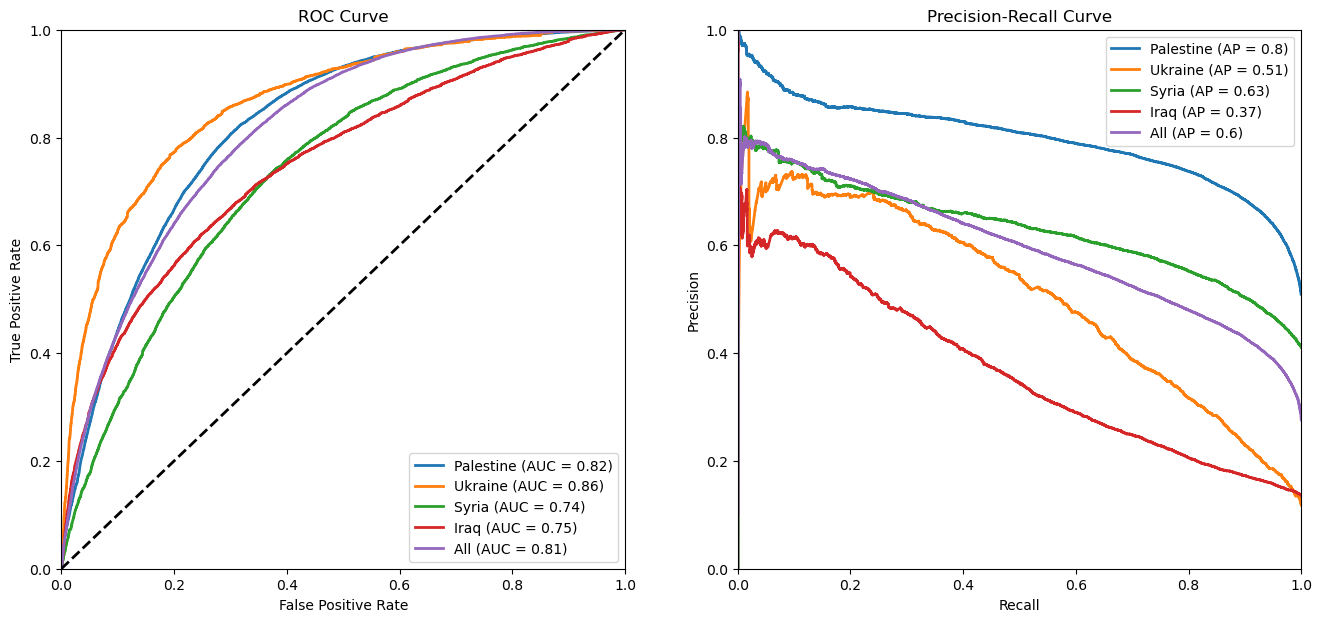

<Figure size 800x800 with 0 Axes>

In [4]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
import umap
#increase fontsize


def get_roc(df, cols, balance=False, geo_level='country'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    aps=[]
    aucs=[]
    ns=[]
    n=len(df[geo_level].unique())
    #colors = plt.cm.Set1(np.linspace(0,1,n))
    colors=["red","#003f5c","#2f4b7c","#665191","#a05195","#d45087","#f95d6a","#ff7c43","#ffa600","green","blue","olive"]
    print(colors)
    i=-1

    for loc in df[geo_level].unique():
        i+=1
        sub=df[(df[geo_level]==loc)]
        fpr, tpr, roc_thresholds = roc_curve(sub['class'], sub[cols], sample_weight=sub['area'])
        roc_auc = auc(fpr, tpr)

        if balance:
            pos=sub[sub['class']==1]
            try:
                sub=pd.concat([pos, sub[sub['class']==0].sample(n=len(pos))])
            except:
                sub=pd.concat([pos, sub[sub['class']==0].sample(n=len(pos), replace=True)])
    

        average_precision = average_precision_score(sub['class'], sub[cols], sample_weight=sub['area'])
        precision, recall, pr_thresholds = precision_recall_curve(sub['class'], sub[cols], sample_weight=sub['area'])

        #print precision at each integer threshold between 2 and 8
        for threshold in range(2,8):
            #closest to integer 
            ix = np.argmin(np.abs(pr_thresholds - threshold))

            print(loc, threshold, np.round(precision[ix],2), np.round(recall[ix],2))
        f1=(2 * (precision * recall) / (precision + recall))
        f1=f1[~np.isnan(f1)]
        ix = np.argmax(f1)
        cutoff = pr_thresholds[ix]    
        #print(loc, cutoff)

        metrics=calculate_metrics(sub['class'], sub[cols]>cutoff, sub['area'])
        cm=confusion_matrix(sub['class'], sub[cols]>cutoff)
        #print(cm)
        ax1.plot(fpr, tpr , lw=2, label='{} (AUC = {})'.format(loc, round(roc_auc, 2)))
        ax2.plot(recall, precision, lw=2, label='{} (AP = {})'.format(loc, round(average_precision, 2)))
        aps.append(average_precision)
        aucs.append(roc_auc)
        ns.append(len(sub))


    if balance:
        all=pd.concat([df[df['class']==1], df[df['class']==0].sample(n=len(df[df['class']==1]))])
    else:
        all=df    
    
    #all=scale_dataframe(all, cols)
    #pca = PCA(n_components=1)
    #pca.fit(all[cols])
    #all['pc']=pca.transform(all[cols])
    fpr, tpr, thresholds = roc_curve(all['class'], all[cols], sample_weight=all['area'])
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    cutoff = thresholds[optimal_idx]
    plt.figure(figsize=(8,8))
    ax1.plot(fpr, tpr, lw=2, label='{} (AUC = {})'.format('All', round(roc_auc, 2)))
    ax1.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

    average_precision = average_precision_score(all['class'], all[cols], sample_weight=all['area'])
    precision, recall, _ = precision_recall_curve(all['class'], all[cols], sample_weight=all['area'])
    ax2.plot(recall, precision, lw=2, label='{} (AP = {})'.format('All', round(average_precision, 2)))

    print('Average AP: ', np.average(aps, weights=ns))
    print('Average AUC: ', np.average(aucs, weights=ns))

    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc="lower right")
    ax1.set_title('ROC Curve')
   
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.0])

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.0])

    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    plt.tight_layout()
    ax2.legend()
    fig.savefig('../figs/roc.png', dpi=300)  
    #plt.show()
#geometric mean 
fp['combined']=fp[['max_change','k50','k100']].mean(axis=1)

#cols=['max_change','VV','VH','k20','k50','k100','k150','B2','B3','B4','B8','B12', 'coh_change','coherence','coh_pre']
get_roc(fp, ['combined'], balance=False, geo_level='country')
#get_roc(pt.dropna(), 'k50')  
#get_roc(gr.dropna(), 'k50')  


\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Palestine & Ukraine   & Syria     & Iraq      & All       \\
\hline
Intercept      & 0.450***  & -0.700*** & -0.452*** & -0.655*** & 0.317***  \\
               & (0.081)   & (0.039)   & (0.101)   & (0.085)   & (0.038)   \\
k50            & 0.499***  & 0.413***  & 0.677***  & 0.546***  & 0.494***  \\
               & (0.024)   & (0.013)   & (0.043)   & (0.025)   & (0.011)   \\
b\_count       & 0.008***  & 0.004***  & 0.012***  & 0.004***  & 0.007***  \\
               & (0.000)   & (0.000)   & (0.000)   & (0.000)   & (0.000)   \\
R-squared      & 0.574     & 0.574     & 0.617     & 0.467     & 0.710     \\
R-squared Adj. & 0.573     & 0.573     & 0.616     & 0.466     & 0.710     \\
N              & 1784      & 4977      & 1188      & 1141      & 9090      \\
\hline
\end{tabular}
\end{center}
\end{table}


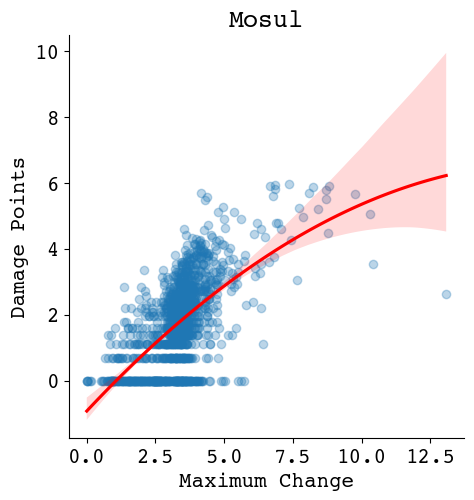

,Palestine,Ukraine,Syria,Iraq,All
Intercept,0.450***,-0.700***,-0.452***,-0.655***,0.317***
,(0.081),(0.039),(0.101),(0.085),(0.038)
k50,0.499***,0.413***,0.677***,0.546***,0.494***
,(0.024),(0.013),(0.043),(0.025),(0.011)
b_count,0.008***,0.004***,0.012***,0.004***,0.007***
,(0.000),(0.000),(0.000),(0.000),(0.000)
R-squared,0.574,0.574,0.617,0.467,0.710
R-squared Adj.,0.573,0.573,0.616,0.466,0.710
N,1784,4977,1188,1141,9090


In [96]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col


def run_regression(dvar, ivar, gr, covars=False, p_loc='Raqqa', geo_level='country'):

    min_pts=-1
    reg=f'{dvar} ~ {ivar}'
    if covars:
        reg=reg+' + '+' + '.join(covars)
    #gr['k50_exp']=gr['k50'].apply(lambda x: np.exp(x))
    for loc in gr[geo_level].unique():
        sub=gr[(gr[geo_level]==loc)&(gr['damage_pts']>min_pts)]
        #robust regression
        model= ols(reg, data=sub).fit() # fit the model
        models.append(model)
    
    model= ols(reg, data=gr[gr['damage_pts']>min_pts]).fit() # fit the model
    models.append(model)

    #only show coefs for k50
    table=summary_col( # create a regression table 
        models,
        stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
        float_format='%0.3f', # set the decimal places to 3
        model_names=list(gr[geo_level].unique())+['All'], # set the name of the model
        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, # add the number of observations and R-squared to the table
        regressor_order=['Intercept', ivar, 'b_count'], # set the order of the coefficients in the table
        drop_omitted=True,

    )

    #to latex 
    print(table.as_latex())
    #print(table)

    plot_data=gr[(gr['damage_pts']>min_pts)&(gr['loc']==p_loc)]

    sns.lmplot(data=plot_data, x=ivar, y=dvar,order=2, line_kws={'color':'red'}, scatter_kws={'alpha':0.3}, truncate= True)
    plt.xlabel('Maximum Change')
    plt.ylabel('Damage Points')
    plt.title(p_loc)
    #plt.ylim(-30,plot_data['damage_pts'].max()+1)
    plt.show()
    return table

models=[]
gr['k50_log']=gr['k50'].apply(lambda x: np.log(x))
gr['damage_pts_log']=gr['damage_pts'].apply(lambda x: np.log(1+x))
gr['db_count_log']=gr['db_count'].apply(lambda x: np.log(1+x))

run_regression('db_count_log', 'k50', gr.fillna(0), covars=['b_count', 'loc'], p_loc='Mosul', geo_level='country')


In [ ]:
# plot boxplots
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

sns.violinplot(x='class', y='k50', data=pt[pt['period']==2], ax=ax, )
#set y axis limits
plt.ylim(0, 7)

plt.show()


# Geographic Plots

In [90]:
loc='Mosul'

def bivariate_plot(loc, var1, var2, dpi=400):

    sub=gr[gr['loc']==loc].fillna(0)

    percentile_bounds = [25, 50, 75, 100]

    ### function to convert hex color to rgb to Color object (generativepy package)
    def hex_to_Color(hexcode):
        rgb = ImageColor.getcolor(hexcode, 'RGB')
        rgb = [v/256 for v in rgb]
        rgb = Color(*rgb)
        return rgb
    
    ### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
    c00 = hex_to_Color('#e8e8e8')
    c10 = hex_to_Color('#64acbe')
    c01 = hex_to_Color('#c85a5a')
    c11 = hex_to_Color('#574249')
    
    ### now create square grid of colors, using color interpolation from generativepy package
    num_grps = len(percentile_bounds)
    c00_to_c10 = []
    c01_to_c11 = []
    colorlist = []
    for i in range(num_grps):
        c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
        c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
    for i in range(num_grps):
        for j in range(num_grps):
            colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))
    
    ### convert back to hex color
    colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]


    def get_bivariate_choropleth_color(p1, p2):
        if p1>=0 and p2>=0:
            count = 0
            stop = False
            for percentile_bound_p1 in percentile_bounds:
                for percentile_bound_p2 in percentile_bounds:
                    if (not stop) and (p1 <= percentile_bound_p1):
                        if (not stop) and (p2 <= percentile_bound_p2):
                            color = colorlist[count]
                            stop = True
                    count += 1
        else:
            color = [0.8,0.8,0.8,1]
        return color

    fpr, tpr, thresholds = roc_curve(sub['class'], sub[var2])
    optimal_idx = np.argmax(tpr - fpr)
    cutoff = thresholds[optimal_idx]

    sub['p1']=sub[var1].replace(0,np.nan).rank(pct=True).fillna(0)*100

    #sub['p1']=sub['damage_pts'].rank(pct=True)*100
    sub['p2']=sub[var2].apply(lambda x: x if x>cutoff else np.nan).rank(pct=True).fillna(0)*100
    ### plot map based on bivariate choropleth

    fig, ax = plt.subplots(1,1, figsize=(10,10))

    sub['color_bivariate'] = sub.apply(lambda x: get_bivariate_choropleth_color(x['p1'], x['p2']), axis=1)

    sub.plot(ax=ax, color=sub['color_bivariate'], alpha=1, legend=False)

    #mapbox://styles/oballinger/clq3p9c9n003w01pe012k5pa0
    cx.add_basemap(ax, crs=sub.crs.to_string(), source=cx.providers.MapBox(accessToken=mapbox_token, url='https://api.mapbox.com/styles/v1/oballinger/clq3pnfvc00ct01pl7af9hyy7/tiles/{z}/{x}/{y}{r}?access_token={accessToken}'), alpha=0.5, attribution='Mapbox')
    convert_ticks(sub, ax, 'EPSG:4326')


    scalebar = ScaleBar(10, units='m', location='lower right')
    ax.add_artist(scalebar)

    ax.set_title('Predicted and Observed Damage Intensity, {}'.format(loc), fontsize=20)
    ### now create inset legend
    ax=ax.inset_axes([0.15, 0.8, 0.15, 0.15])
    ax.set_aspect('equal', adjustable='box')
    count = 0
    xticks = [0]
    yticks = [0]
    for i,percentile_bound_p1 in enumerate(percentile_bounds):
        for j,percentile_bound_p2 in enumerate(percentile_bounds):
            percentileboxes = [Rectangle((i,j), 1, 1)]
            pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=1)
            count += 1
            ax.add_collection(pc)
            if i == 0:
                yticks.append(percentile_bound_p2)
        xticks.append(percentile_bound_p1)
    

    _=ax.set_xticks(list(range(len(percentile_bounds)+1)), xticks)
    _=ax.set_xlabel('Observed Damage %')
    _=ax.set_yticks(list(range(len(percentile_bounds)+1)), yticks)
    _=ax.set_ylabel('Predicted Damage %')
    # add scalebar 

    #tight layout
    plt.tight_layout()
    plt.savefig(f'../figs/{loc}_bivariate.png', dpi=dpi)
    plt.show()
cols=amp+coh+opt
#pc=PCA(n_components=1)
#pc.fit(cgr[cols])
#cgr['pc']=pc.transform(cgr[cols])


bivariate_plot("Gaza", 'db_count_log', 'k50')


#for loc in gr['loc'].unique():
#    bivariate_plot(loc, 'db_count', 'k50')


KeyError: 'db_count_log'

Accuracy: 0.7357807393398716
F1: 0.6570589818590067
Precision: 0.5563185836389638
Recall: 0.8023521183722618
0.4945337445326091
('max_change', 'k20', 'k50', 'k100', 'k150')


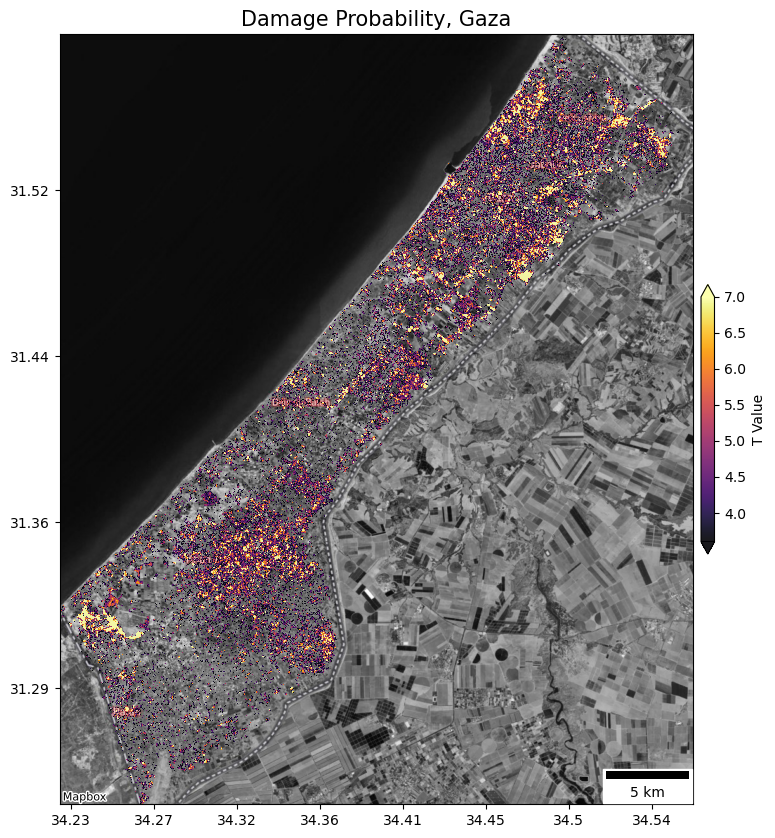

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import xarray as xr

def plot_footprints(loc, offsets, data_type='footprints', band='k20', mode='prc', buffer=True):

    sub=fp[(fp['loc']==loc)].fillna(0)
    #sub=sub[sub['area']>100]
    if data_type=='points':
        sub['geometry']=sub['geometry'].apply(lambda x: x.centroid)
    if data_type=='footprints' and buffer:
        sub['geometry']=sub['geometry'].apply(lambda x: x.buffer(10))

    sub=inference(sub, cols, mode)
    #get percent predicted to be damaged
    sub['pred_pct']=sub['pred'].sum()/len(sub)
    print(sub['pred_pct'].mean())
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    #cmap={'TP':'red','FP':'orange','TN':'#1db01a','FN':'#34b1eb'}
    #cmap={'TP':'red','FP':'orange','TN':'cyan','FN':'blue'}
    cmap={'TP':'red','FP':'orange','TN':'green','FN':'purple'}
    sub.sort_values(by='val', ascending=True, inplace=True)
    if data_type=='footprints' or data_type=='points':
        for ctype, data in sub.groupby('val'):
            color=cmap[ctype]
            data.plot(ax=ax, color=color, alpha=1, legend=True, markersize=10, label=ctype)

        handles = [plt.scatter([0],[0], marker='s', color=c) for c in cmap.values()]
        tot=sub['area'].sum()
        tps=str(int(((sub[sub['val']=='TP']['area'].sum()/tot)*100)))+ '%'
        fps=str(int(((sub[sub['val']=='FP']['area'].sum()/tot)*100)))+ '%'
        fns=str(int(((sub[sub['val']=='FN']['area'].sum()/tot)*100)))+ '%'
        tns=str(int(((sub[sub['val']=='TN']['area'].sum()/tot)*100)))+ '%'
        
        #tps=str(int(((len(sub[sub['val']=='TP'])/len(sub))*100)))+ '%'
        #fps=str(int(((len(sub[sub['val']=='FP'])/len(sub))*100)))+ '%'
        #fns=str(int(((len(sub[sub['val']=='FN'])/len(sub))*100)))+ '%'
        #tns=str(int(((len(sub[sub['val']=='TN'])/len(sub))*100)))+ '%'

        labels=[f'TP {tps}', f'FP {fps}', f'TN {tns}', f'FN {fns}']
        
        ax.legend(handles, labels)

        
        title=f'Predicted and Observed Damage, {loc}'

    if data_type=='raster':
        datestr=sub['date'].max().strftime('%Y%m%d')
        ras=xr.open_dataset(f'../data/GEE/{loc}_{datestr}_2_raster.tif', engine='rasterio', mask_and_scale=True)
        sub_crs=sub.crs.to_string()
        ras=ras.rio.reproject(sub_crs)
        #get index position of band
        cutoff=3.5
        band_pos=list(ras.band_data.attrs['long_name']).index(band)
        #average the first three bands
        print(ras.band_data.attrs['long_name'])
        #drop band 1
        ras=ras.band_data[1:3].mean(axis=0)
        ras=ras.where(ras>cutoff)
        #ras.band_data[band_pos].plot(ax=ax, cmap='jet',alpha=0.8, vmin=cutoff+0.1, vmax=cutoff*2, cbar_kwargs={'shrink':0.5, 'aspect':40, 'label':'T Value'})

        #custom cmap
        
        ras.plot(ax=ax, alpha=0.9, vmin=cutoff+0.1, vmax=cutoff*2, cmap='inferno',
                 cbar_kwargs={'shrink':0.35, 'aspect':20,'pad':.01, 'label':'T Value'}, )

        title=f'Damage Probability, {loc}'  
        #sub['geometry']=sub['geometry'].apply(lambda x: x.centroid)
        #sub=sub[sub['pred']==1]
        #sub.plot(ax=ax, color='black', alpha=.5, markersize=0.5, legend=False, marker='x')  
        ax.set_xlabel('')
        ax.set_ylabel('')

    scalebar = ScaleBar(1, units='m', location='lower right')
    ax.add_artist(scalebar)

    minx, miny, maxx, maxy = sub.total_bounds
    w, h = maxx - minx, maxy - miny
    ax.set_xlim(minx + (w * offsets[0]), maxx - (w * offsets[1]))
    ax.set_ylim(miny + (h * offsets[2]), maxy - (h * offsets[3]))

    convert_ticks(sub, ax, 'EPSG:4326')

    cx.add_basemap(ax=ax, crs=sub.crs.to_string(), 
                   source=cx.providers.MapBox(accessToken=mapbox_token, 
                                              url='https://api.mapbox.com/styles/v1/oballinger/clq3pnfvc00ct01pl7af9hyy7/tiles/{z}/{x}/{y}{r}?access_token={accessToken}'), 
                                                alpha=0.99, attribution='Mapbox')

    plt.title(title, fontsize=15)
    #plt.title('')
    plt.savefig(f'../figs/{loc}_{data_type}.png', dpi=500, bbox_inches='tight')
    plt.show()

#cols=amp+coh+opt
cols=['combined']
#plot_footprints('Mariupol', [0.01, 0.6, 0.01, 0.35], data_type='raster') # West Mariupol
#plot_footprints('Mariupol', [0.01, 0.6, 0.01, 0.35], data_type='footprints') # West Mariupol
#plot_footprints('Mariupol', [0.115, 0.78, 0.35, 0.51], data_type='footprints') #  Mariupol zoom

#plot_footprints('Mariupol', [0.57,0,0.2,0.1], data_type='raster', band='k20') # West Mariupol
#plot_footprints('Mariupol', [0.57,0,0.2,0.1], data_type='footprints') # West Mariupol

#plot_footprints('Raqqa', [0, 0, 0, 0], data_type='footprints')
#plot_footprints('Raqqa', [0, 0, 0, 0], data_type='raster', band='k50')
#plot_footprints('Irpin', [0, 0, 0, 0], data_type='footprints')


#plot_footprints('Chernihiv', [0.0, 0.0, 0.0, 0], data_type='footprints')
#plot_footprints('Chernihiv', [0.82, 0.02, 0.65, .21], data_type='footprints') # top right zoom
#plot_footprints('Chernihiv', [0.88, 0.02, 0.7, .22], data_type='footprints') # top right full zoom 
#plot_footprints('Chernihiv', [0.08, 0.86, 0.60, .34], data_type='footprints', buffer=False) # top left full zoom 
#plot_footprints('Kharkiv', [0.0, 0.0, 0.0, 0], data_type='footprints')

#plot_footprints('Rubizhne', [0,0,0,0], data_type='footprints')
#plot_footprints('Rubizhne', [0,0,0,0], data_type='raster')
#plot_footprints('Mosul', [0, 0, 0, 0], data_type='raster', band='k50')
#plot_footprints('Mosul', [0, 0, 0, 0], data_type='footprints')

#plot_footprints('Aleppo', [0.1, 0.1, 0.1, 0.1], data_type='raster')

#plot_footprints('Gaza', [0.55, 0.0, 0.7, 0.01], data_type='raster')
#plot_footprints('Gaza', [0.55, 0.0, 0.7, 0.01], data_type='footprints')
plot_footprints('Gaza', [0.0, 0.0, 0.0, 0], data_type='raster')

#plot_footprints('Gaza', [0.0, 0.0, 0.0, 0], data_type='footprints')

#for loc in fp['loc'].unique():
    #plot_footprints(loc, [0, 0, 0, 0], data_type='footprints', mode='prc')
    #plot_footprints(loc, [0, 0, 0, 0], data_type='raster')

#plot_footprints('Aleppo', [0, 0, 0, 0], data_type='footprints')


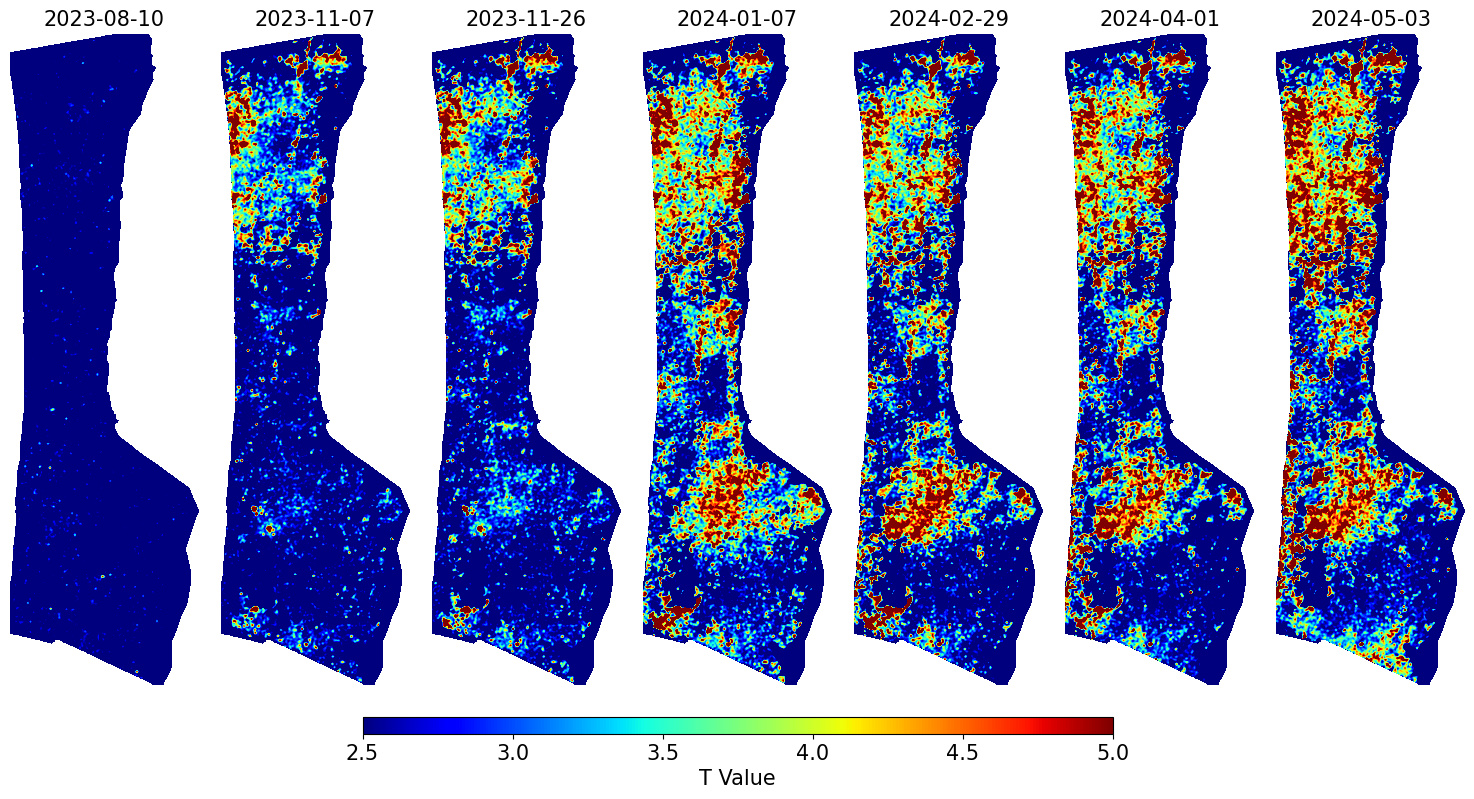

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import xarray as xr
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
import contextily as cx  # Assuming you use contextily for basemaps
from matplotlib_scalebar.scalebar import ScaleBar  # Assuming you use ScaleBar for scale bar
import cartopy.crs as ccrs
from osgeo import gdal  # For read and manipulate rasters
from affine import Affine  # For easly manipulation of affine matrix
from rasterio.warp import reproject, Resampling
import glob
from datetime import datetime

from rasterio.mask import mask
#increase font size 
plt.rcParams.update({'font.size': 15})
#plt.rcParams.update({'font.family': 'Courier'})
def rotate_raster(in_file, ax, admin, unosat=False, angle=0, shift_x=0, shift_y=0,adj_width=0, adj_height=0):

    datestr=in_file.split('_')[1]
    date=datetime.strptime(datestr, '%Y%m%d').strftime('%Y-%m-%d')
    src=rio.open(in_file)
    if unosat:
        pts=gpd.read_file(f'../data/Gaza/UNOSAT/UNOSAT_GAZA_{datestr}.shp')
        pts['geometry']=pts['geometry'].apply(lambda x: x.buffer(0.0006))
        pts=pts.to_crs(src.crs)

    # Get the old transform and crs
    src_transform = src.transform 
    crs = src.crs
    admin=admin.to_crs(src.crs)

    # Affine transformations for rotation and translation
    rotate = Affine.rotation(angle)
    trans_x = Affine.translation(shift_x,0)
    trans_y = Affine.translation(0, -shift_y)

    # Combine affine transformations
    dst_transform = src_transform * rotate * trans_x * trans_y
    mask=admin.geometry
    out_meta = src.meta.copy()
    out_image, out_transform = rio.mask.mask(src, mask, crop=True)
    band=out_image[2]
    #band=out_image.mean(axis=0)

    # Get the new shape
    y,x = band.shape
    dst_height = y + adj_height
    dst_width = x + adj_width

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "transform": dst_transform,
            "height": dst_height,
            "width": dst_width,
            "nodata": np.nan,  
        }
    )

    #new raster full of nans 
    rotated = np.zeros((dst_height, dst_width), dtype=np.float32)
    #rotated[:] = np.nan
    reproject(
        source=band,
        destination=rotated,
        src_transform=out_transform,
        src_crs=crs,
        dst_transform=dst_transform,
        dst_crs=crs,
        resampling=Resampling.nearest,
    )

    rotated = np.where(rotated==0, np.nan, rotated)
    admin_r=rio.features.rasterize(admin.geometry, out_shape=(dst_height, dst_width), transform=dst_transform, fill=np.nan, all_touched=True)

    ax.set_title(date, fontsize=15)
    ax.axis('off')
    if unosat:
        unosat_cmap='plasma'
        ax.imshow(admin_r, cmap=unosat_cmap)
        unosat_r=rio.features.rasterize(pts.geometry, out_shape=(dst_height, dst_width), transform=dst_transform, fill=np.nan, all_touched=True, default_value=1)
        ax.imshow(unosat_r, cmap=unosat_cmap, vmin=0, vmax=1, alpha=1)
    else:
        ax.imshow(admin_r, cmap=cmap)
        ax.imshow(rotated, cmap=cmap, vmin=2.5, vmax=5)

    return rotated

def assembly():
    tifs = glob.glob('../data/Gaza/*.tif')#[:2]
    admin=gpd.read_file('../data/Gaza/admin_bounds/GazaStrip_MunicipalBoundaries.shp')

    tifs.sort(key=lambda x: x.split('_')[1])
    fig, ax = plt.subplots(1,len(tifs), figsize=(15,8.5))
    kwargs={'angle':45,'shift_x':2200, 'shift_y':2300, 'adj_width':-2500, 'adj_height':750}

    for i, file in enumerate(tifs):
        rotate_raster(file, ax[i], admin, **kwargs)

    cax = fig.add_axes([0.25, 0.06, 0.5, 0.02])
    norm = plt.Normalize(vmin=2.5, vmax=5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax, orientation='horizontal', label='T Value')
    #add second set of labels on top of colorbar 
    plt.tight_layout()
    plt.savefig('../figs/gaza_multitemporal.png', dpi=300)
    plt.show()

cmaps=['viridis','magma','inferno','plasma','hot','afmhot','gist_heat','jet']
#for cmap in cmaps:
cmap='jet'
assembly()


In [ ]:
!conda create -n geospatial python=3.8 geopandas rasterio matplotlib contextily cartopy -y

In [ ]:
from shapely.geometry import Point
from shapely.ops import nearest_points
from joblib import Parallel, delayed

def nearest(row, geom):
    src = row['geometry']
    nearest = nearest_points(src, geom)
    dist = src.distance(nearest[1])
    return dist 

def get_nearest(loc, fp, amp):
    dist_df = pd.DataFrame()
    
    sub = fp[fp['loc'] == loc]
    sub = inference(sub, amp, 'prc')
    
    pos = sub[sub['val'].isin(['TP', 'FN'])]
    fp = sub[sub['val'] == 'FP']
    tn = sub[sub['val'] == 'TN']

    geom = pos['geometry'].unary_union

    fp['nearest'] = fp.apply(lambda x: nearest(x, geom), axis=1)
    tn['nearest'] = tn.apply(lambda x: nearest(x, geom), axis=1)

    dist_df = pd.concat([dist_df, fp, tn])
    return dist_df

def parallel_get_nearest(locs, fp, amp):
    dist_dfs = Parallel(n_jobs=8)(delayed(get_nearest)(loc, fp, amp) for loc in locs)
    return pd.concat(dist_dfs)

locs = fp['loc'].unique()
print(locs)
#dist_df = parallel_get_nearest(locs, fp, ['k50'])
dist_df= pd.DataFrame()
for loc in locs:
    dist_df = pd.concat([dist_df, get_nearest(loc, fp, ['k50'])])

#dist_df['nearest'].hist(bins=50, range=(0, 200), figsize=(5, 5))


['Gaza' 'Lysychansk' 'Sievierodonetsk' 'Rubizhne' 'Kharkiv' 'Mariupol'
 'Irpin' 'Hostomel' 'Chernihiv' 'Raqqa' 'Mosul' 'Aleppo']
Accuracy: 0.7551957115130383
F1: 0.7843344447936869
Precision: 0.7103752305076458
Recall: 0.8754835639167672
Accuracy: 0.8110075923171695
F1: 0.5355024850340929
Precision: 0.5104193633768165
Recall: 0.5631782957922067
Accuracy: 0.5864567083814433
F1: 0.6539674268357912
Precision: 0.5151261836739127
Recall: 0.8952676776661918
Accuracy: 0.659010486842957
F1: 0.680152933388178
Precision: 0.5525549161967432
Recall: 0.8843763873205861
Accuracy: 0.9649272552613668
F1: 0.27987673301799787
Precision: 0.2624087714322532
Recall: 0.29983615106746736
Accuracy: 0.626792962639454
F1: 0.7219710851261443
Precision: 0.5886563600262048
Recall: 0.9333494642618078
Accuracy: 0.8256672152982586
F1: 0.5853164313025073
Precision: 0.5435687547247061
Recall: 0.6340102828240979
Accuracy: 0.6529960782612757
F1: 0.0
Precision: 0.0
Recall: 0.0


ValueError: Cannot set a DataFrame with multiple columns to the single column nearest

32.027746725827456 421.64222717707025
0.23860019512819283
TtestResult(statistic=153.38248454348755, pvalue=0.0, df=268891.0)


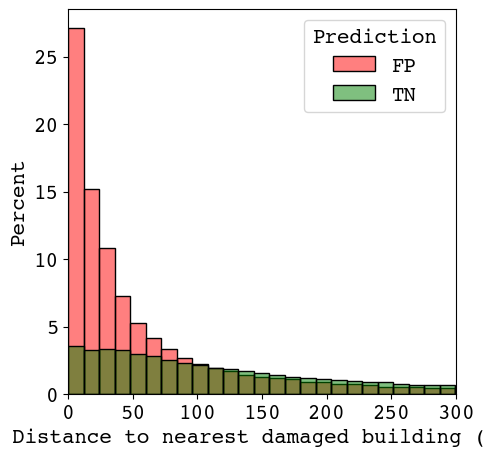

In [ ]:
#tn_d=np.log(1+dist_df[dist_df['val'] == 'TN']['nearest'])
#fp_d=np.log(1+dist_df[dist_df['val'] == 'FP']['nearest'])
tn_d=dist_df[dist_df['val'] == 'TN']['nearest']
fp_d=dist_df[dist_df['val'] == 'FP']['nearest']
print(fp_d.median(), tn_d.median())
print(len(dist_df[(dist_df['val'] == 'FP')&(dist_df['nearest']<10)])/len(fp_d))
from scipy.stats import ttest_ind
print(ttest_ind(tn_d, fp_d))
fix, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, 300)
hist_df=dist_df[dist_df['val'].isin(['FP','TN'])].sort_values(by='val', ascending=False)
#hist_df['nearest']=np.log(1+hist_df['nearest'])
sns.histplot(data=hist_df,
             common_norm=False, x='nearest', hue='val', bins=1000, palette=['green','red'], alpha=0.5, stat='percent', ax=ax, multiple='layer', legend=False)
plt.xlabel('Distance to nearest damaged building (m)')
plt.legend(title='Prediction', loc='upper right', labels=['FP', 'TN'])
plt.savefig('../figs/prox_hist.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
spo=dist_df[(dist_df['val'] == 'FP')&(dist_df['nearest']<30)]

sub=fp
var='k50'
precision, recall, thresholds = precision_recall_curve(sub['class'], sub[var], sample_weight=sub['area'])
f1=(2 * (precision * recall) / (precision + recall))
f1=f1[~np.isnan(f1)]
ix = np.argmax(f1)
cutoff = thresholds[ix]
y_pred = np.where(sub[var] > cutoff, 1, 0)

sub['pred'] = y_pred
#sub=sub[~sub.index.isin(spo.index)]
# if index is in spo, then sub class =1 
sub['class'] = sub.apply(lambda x: 1 if x.name in spo.index else x['class'], axis=1)
metrics = calculate_metrics(sub['class'], sub['pred'], sub['area'])
print_metrics(metrics)

#test=fp[~fp.index.isin(spo.index)]




Accuracy: 0.7182987814361043
F1: 0.2599452322540813
Precision: 0.16385224536054002
Recall: 0.6285873095311751


In [ ]:
import overpass

loc='Mariupol'
buffer=0.1
bbox=fp[fp['loc']==loc].to_crs('EPSG:4326').total_bounds
bbox=bbox.tolist()
print(bbox)
query=f'(way["building"](bbox:{bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]});relation["building"]["type"="multipolygon"](bbox:{bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]}););out;>;out qt;'
print(query)
api = overpass.API()
result = api.get(query,
    responseformat = "geojson",
    verbosity = "geom"
)
print(len(result['features']))
df=gpd.GeoDataFrame.from_features(result['features'])
#df.explore()

[37.49449830247809, 47.08359452414627, 37.693699827218666, 47.137371272656516]
(way["building"](bbox:47.08359452414627,37.49449830247809,47.137371272656516,37.693699827218666);relation["building"]["type"="multipolygon"](bbox:47.08359452414627,37.49449830247809,47.137371272656516,37.693699827218666););out;>;out qt;


UnknownOverpassError: Received corrupt data from Overpass (incomplete polygon).

In [ ]:
import overpass

# Specify your bounding box coordinates
min_lat = 36.15
min_lon = 37.10
max_lat = 36.30
max_lon = 37.30

# Define the bounding box
bbox = min_lat, min_lon, max_lat, max_lon

# Overpass query string
overpass_query = f"""
(
  way["building"](bbox: {bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
);
out body;
>;
out skel qt;
"""
print(overpass_query)
# Perform the Overpass API query
api = overpass.API()
result = api.get(overpass_query,
    responseformat = "geojson",
    verbosity = "geom"
)
# Extract building footprints from the response
building_footprints = [feature.geometry for feature in result['features']]

# Now you can use the building footprints as needed, for example, create a GeoDataFrame
import geopandas as gpd
from shapely.geometry import shape

gdf = gpd.GeoDataFrame(geometry=building_footprints)

# Print or use the GeoDataFrame
print(gdf)



(
  way["building"](bbox: 36.15,37.1,36.3,37.3);
);
out body;
>;
out skel qt;



NameError: name 'response' is not defined

In [ ]:
#read geojson
loc='mosul'
path=f'../data/overpass/{loc}.geojson'
gdf=gpd.read_file(path)
gdf.explore()
#gdf.to_csv(f'../data/overpass/{loc}.csv', index=False)

In [ ]:
gdf['geometry'].to_csv(f'../data/overpass/{loc}_geom.csv')

In [ ]:
import requests
import geopandas as gpd
from shapely.geometry import shape

# Replace this with your Overpass Turbo API query
overpass_query = """
[out:json];
(
  way["building"](bbox:{{bbox}});
);
out body;
>;
out skel qt;
"""

# Specify your bounding box coordinates
bbox = [min_lat, min_lon, max_lat, max_lon]  # Replace with your actual coordinates

# Make the Overpass API request
overpass_url = "https://overpass-api.de/api/interpreter"
response = requests.post(overpass_url, data={'data': overpass_query.format(bbox=','.join(map(str, bbox)))})
data = response.json()

# Function to convert Overpass JSON data to GeoDataFrame
def overpass_json_to_geodataframe(data):
    features = []
    for element in data['elements']:
        if 'geometry' in element:
            geometry = shape(element['geometry'])
            feature = {
                'id': element['id'],
                'geometry': geometry,
                'properties': element['tags']
            }
            features.append(feature)

    gdf = gpd.GeoDataFrame.from_features(features)
    return gdf

# Convert Overpass JSON data to GeoDataFrame
geo_df = overpass_json_to_geodataframe(data)

# Print the GeoDataFrame
print(geo_df)


In [ ]:
import xarray as xr
loc='Aleppo'

grid=pd.read_csv('../Aleppo_2_grid_500.csv')

grid['geometry']=grid['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
grid = gpd.GeoDataFrame(grid, geometry='geometry', crs="EPSG:3857")

grid.reset_index(inplace=True)
grid['patch_ID']=loc+'_'+grid['index'].astype(str)

ras=xr.open_dataset(f'../data/{loc}_2_raster.tif', engine='rasterio', mask_and_scale=True)
sub_crs=grid.crs.to_string()
ras=ras.rio.reproject(sub_crs)
footprints=fp[fp['loc']==loc]



In [ ]:
#delete dir
!rm -rf ../unet_data
!mkdir ../unet_data
!mkdir ../unet_data/images
!mkdir ../unet_data/labels

In [ ]:
for i, row in grid.sample(30).iterrows():
    patch=row['patch_ID']
    minx, miny, maxx, maxy = row['geometry'].bounds
    w, h = maxx - minx, maxy - miny
    sub=ras.rio.clip_box(minx, miny, maxx, maxy)  # Select the first band of the raster dataset
    fp_sub=footprints.cx[minx:maxx, miny:maxy]
    data=fp_sub[['class','geometry']]
    data=data.to_json()
    #save geojson
    with open(f'../unet_data/labels/{patch}.json', 'w') as outfile:
        json.dump(data, outfile)


    sub.band_data.attrs['long_name']=sub.band_data.attrs['long_name'][:3]
    sub.band_data[:3].rio.to_raster(f'../unet_data/images/{patch}.tif')


In [ ]:
import rasterio
import cv2
label_path='../unet_data/labels/'
labels=os.listdir(label_path)

image_path='../unet_data/images/'
images=os.listdir(image_path)

def get_img(path, patch):
    with rasterio.open(path+patch) as src:
        data = src.read()
        data = np.moveaxis(data, 0, -1)
        #make all images 50px by 50 px
        if data.shape[0]<50:
            data=np.pad(data, ((0,50-data.shape[0]),(0,0),(0,0)), 'constant')
        if data.shape[1]<50:
            data=np.pad(data, ((0,0),(0,50-data.shape[1]),(0,0)), 'constant')
    return data

def get_label(path, patch):
    with open(path+patch) as f:
        data = json.load(f)
    data=json.loads(data)
    data=gpd.GeoDataFrame.from_features(data['features'])
    return data

def get_mask(patch, label):
    mask=np.zeros((patch.shape[0], patch.shape[1]))
    for i, row in label.iterrows():


        mask=cv2.fillPoly(mask, np.array(row['geometry'].bounds).astype(int), 1)
    return mask

def get_patches(data, label, patch_size=50, stride=128):
    patches=[]
    masks=[]   
    for i in range(0, data.shape[0], stride):
        for j in range(0, data.shape[1], stride):
            patch=data[i:i+patch_size, j:j+patch_size]
            mask=get_mask(patch, label)
            if patch.shape==(patch_size, patch_size, 3):
                patches.append(patch)
                masks.append(mask)
    return patches, masks

num=2
data=get_img(image_path, images[num])
label=get_label(label_path, labels[num])
mask=get_mask(data, label)
#plt.imshow(mask)
print(label)

In [ ]:
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = rescale  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)


# build model
#model = build_unet(img_shape=(img_height, img_width, img_channels))
#model.summary()

# Etc.

TtestResult(statistic=32.285516720288896, pvalue=7.485081029128896e-48, df=80.55898613068156)


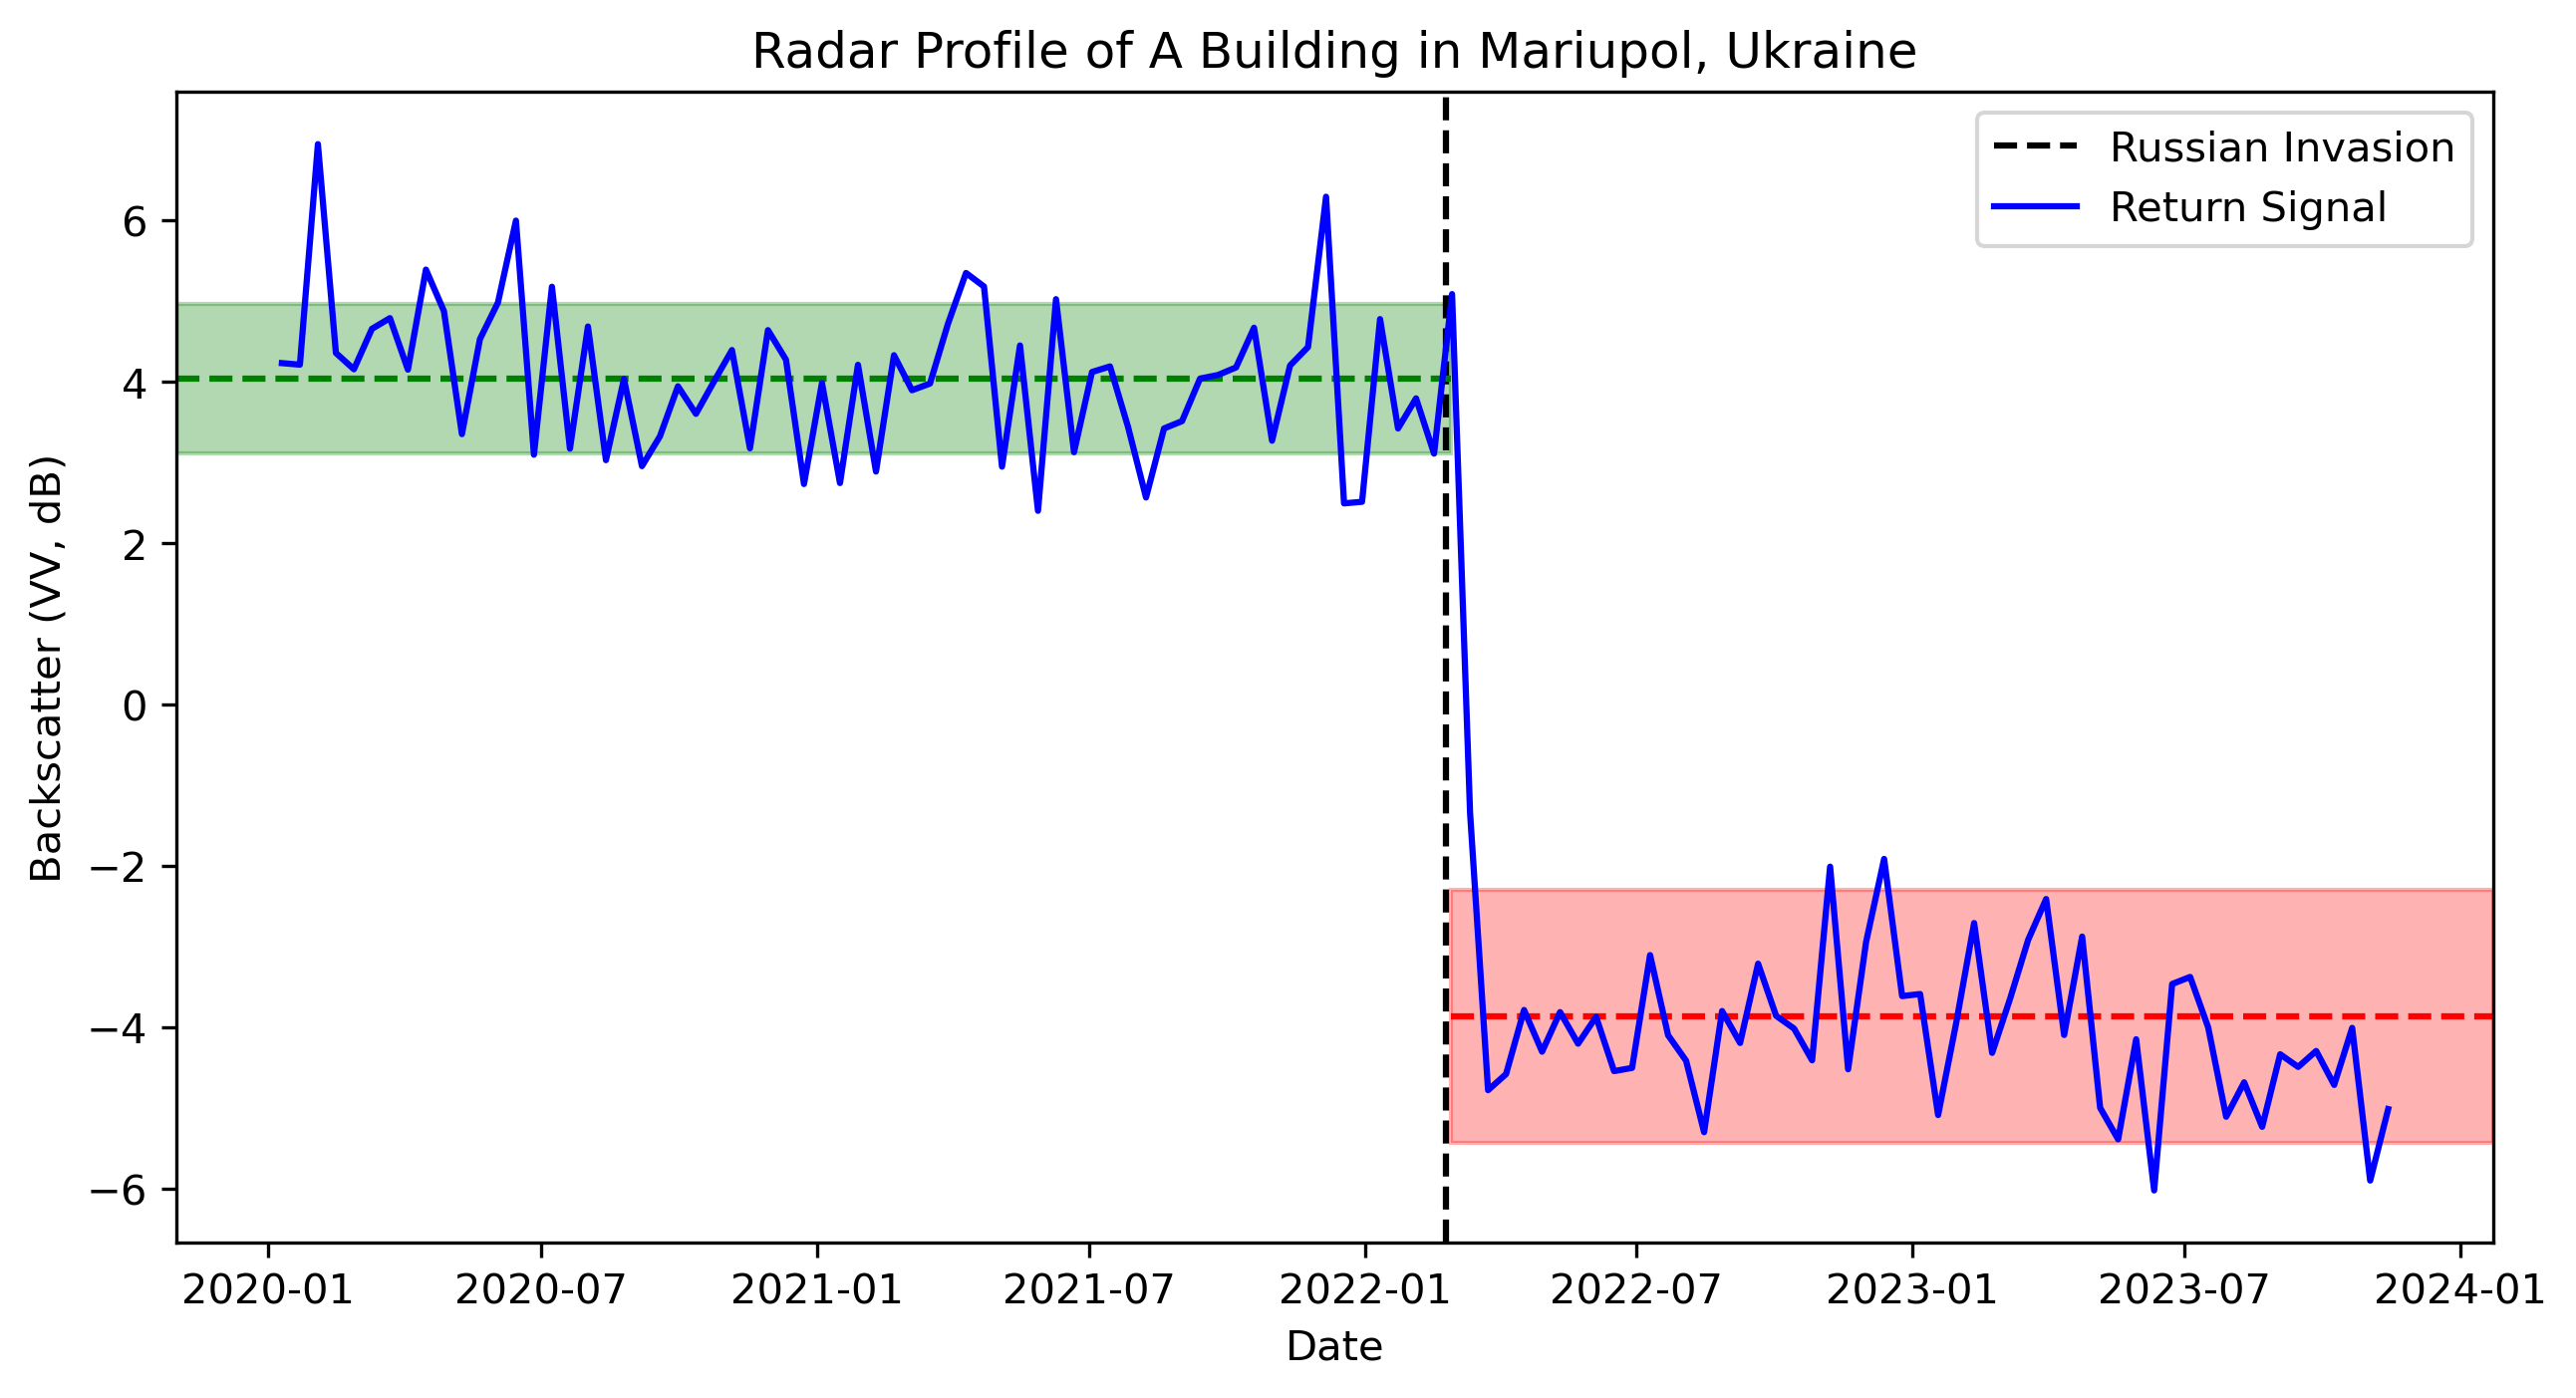

<Figure size 640x480 with 0 Axes>

In [ ]:
#import ttest form scipy
from scipy import stats as ttest

b=pd.read_csv('../single_building.csv', parse_dates=['system:time_start'])
shock_date=pd.to_datetime('2022-02-24')
pre_mean=b[b['system:time_start']<shock_date]['VV'].mean()
post_mean=b[b['system:time_start']>shock_date]['VV'].mean()

pre_sd=b[b['system:time_start']<shock_date]['VV'].std()
post_sd=b[b['system:time_start']>shock_date]['VV'].std()

pre_se=pre_sd/np.sqrt(len(b[b['system:time_start']<shock_date]))
post_se=post_sd/np.sqrt(len(b[b['system:time_start']>shock_date]))

#t=(pre_mean-post_mean)/np.sqrt(pre_se**2+post_se**2)
t=ttest.ttest_ind(b[b['system:time_start']<shock_date]['VV'], b[b['system:time_start']>shock_date]['VV'], equal_var=False)
print(t)
#plot time series
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

ax.axvline(shock_date, color='black', linestyle='--', label='Russian Invasion')

ax.axhline(pre_mean, color='green', linestyle='--', xmax=0.55)#label='Intact µ, σ', xmax=0.55)
ax.axhline(post_mean, color='red', linestyle='--', xmin=0.55)#label='Destroyed µ, σ',xmin=0.55)
#truncate axhspan at 0
ax.axhspan(pre_mean-pre_sd, pre_mean+pre_sd, alpha=0.3, color='green', xmax=0.55)
ax.axhspan(post_mean-post_sd, post_mean+post_sd, alpha=0.3, color='red', xmin=0.55)

ax.plot(b['system:time_start'], b['VV'], color='blue', label='Return Signal')


ax.set_xlabel('Date')
ax.set_ylabel('Backscatter (VV, dB)')
ax.set_title('Radar Profile of A Building in Mariupol, Ukraine')
ax.legend()

plt.show()
plt.savefig('../figs/single_building.png', dpi=800, bbox_inches='tight')

# UNOSAT Points

In [ ]:
pt.columns=[x.lower() for x in pt.columns]
dcols=[]
for col in pt.columns:
    if "dam" in col or "dmg" in col:
        dcols.append(col)
        print(col, pt[col].unique())

pt['damage']=0
#pt['damage']=pt[dcols].astype(str).sum(axis=1)
#pt['damage']

# ACLED 


In [ ]:
import requests
key='Yh6oYUa*GHb8tX*LJnxD'

def get_acled_data(location, start, end):
    url=f'https://api.acleddata.com/acled/read.csv/?key={key}&email=o.ballinger@ucl.ac.uk&location={location}&event_date={start}|{end}&event_date_where=BETWEEN'
    data=requests.get(url)
    df=pd.read_csv(url)
    return df

mosul=get_acled_data('Mosul', '2015-01-01', '2018-01-01')
#aleppo=get_acled_data('Aleppo', '2015-01-01', '2018-01-01')
#mariupol=get_acled_data('Mariupol', '2021-02-22', '2023-02-22')
irpin=get_acled_data('Irpin', '2021-02-22', '2023-02-22')
gaza=get_acled_data('Gaza', '2022-10-10','2025-01-01')
#lysychansk=get_acled_data('Lysychansk', '2021-02-22', '2023-02-22')
#daara=get_acled_data('Daara', '2015-01-01', '2017-01-01')
#hama=get_acled_data('Hama', '2015-01-01', '2017-01-01')
#raqqa=get_acled_data('Raqqa', '2015-01-01', '2019-01-01')
#damascus=get_acled_data('Damascus', '2015-01-01', '2019-01-01')
#daraa=get_acled_data('Daraa', '2015-01-01', '2018-01-01')
#kharkiv=get_acled_data('Kharkiv', '2021-02-22', '2023-02-22')


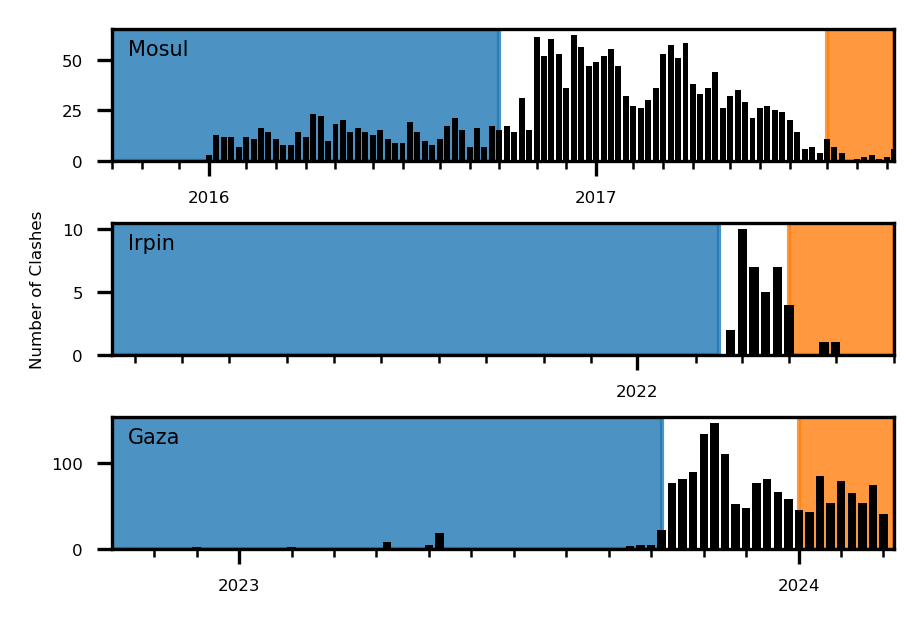

In [ ]:
def plot_acled(df, location, unosat, train, ax=ax):
    
    train=pd.to_datetime(train)
    unosat=pd.to_datetime(unosat)
    blank=pd.DataFrame({'event_date':pd.date_range(unosat-pd.DateOffset(years=3), unosat+pd.DateOffset(years=3), freq='D')})
    blank['week']=blank['event_date'].dt.to_period('W')
    blank=blank.groupby(['week']).count()['event_date'].reset_index()[['week']]
    df['event_date']=pd.to_datetime(df['event_date'])
    df['week']=df['event_date'].dt.to_period('W')
    df=df[df['event_type'].isin(['Battles', 'Explosions/Remote violence', 'Strategic Developments'])]
    g=df.groupby(['week']).count()['year'].reset_index().rename(columns={'year':'count'})
    g=g.merge(blank, on='week', how='outer').fillna(0).sort_values('week')
    g['week_of_year']=g['week'].dt.weekofyear.astype(int)
    
    g.plot(x='week', y='count',ax=ax, legend=False, color='black', linewidth=0)
    #g['week'] = pd.to_numeric(g['week'], errors='coerce')

    ax.axvspan(train, train-pd.Timedelta('365 days'), alpha=0.8, color='#1f77b4', )#label='Reference Period')
    ax.axvspan(unosat, unosat+pd.DateOffset(months=2), alpha=0.8, color='#ff7f0e', )#label='Post-Shock Period')

    ax.bar(g['week'], g['count'], color='black', width=0.8)
    ax.set_ylabel('')
    ax.set_xlabel('')   
    ax.text(0.02, 0.8, location, transform=ax.transAxes, fontsize=5)
    # get year for xticks
    xticks=[x for x in g['week'].dt.year.unique() if x>=train.year]
    xticks=[pd.to_datetime(f'{x}-01-01') for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels([x.year for x in xticks])

    #only x tick for unosat
    #ax.set_xticks([unosat])
    #ax.set_xticklabels([unosat.strftime('%Y-%m-%d')])
    #ax.axvline(unosat, color='red', linestyle='--', label='UNOSAT  Assessment', linewidth=0.7)

    ax.set_xlim(train-pd.DateOffset(years=1), unosat+pd.DateOffset(months=2))
    return ax


#tight layout
#reset plot params
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#make font smaller for just this figure
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 4})

fig, ax = plt.subplots(3,1, figsize=(3, 2), dpi=300)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

#plot each subplot
plot_acled(mosul,'Mosul', unosat='2017-08-04', train='2016-10-01', ax=ax[0])
#plot_acled(mariupol, 'Mariupol', unosat='2022-05-18', train='2022-02-20', ax=ax[1])
plot_acled(irpin, 'Irpin', unosat='2022-03-31', train='2022-02-20', ax=ax[1])
#plot_acled(lysychansk,'Lysychansk', unosat='2022-09-21', train='2022-02-20', ax=ax[2])
#plot_acled(kharkiv,'Kharkiv', unosat='2022-06-24', train='2022-02-20', ax=ax[3])

plot_acled(gaza,'Gaza', unosat='2024-01-07', train='2023-10-07', ax=ax[2])
#plot_acled(raqqa,'Raqqa', unosat='2017-10-21', train='2017-05-01', ax=ax[0])
#plot_acled(damascus,'Damascus', unosat='2017-12-03', train='2015-10-07', ax=ax[4])
#plot_acled(daraa,'Daraa', unosat='2017-02-07', train='2016-10-07', ax=ax[5])


ax[1].set_ylabel('Number of Clashes')
#title
#fig.suptitle('Pre- and Post-Conflict Sample Periods', fontsize=6, y=1.02, x=0.53)
#remove first item from legend 
handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]
#add legend
#fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=2, bbox_to_anchor=(0.53, -0.05))
plt.tight_layout()
plt.savefig('../figs/acled.png', dpi=800, bbox_inches='tight')
plt.show()


# SkySat

In [6]:
import glob
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import Point, Polygon
from pyproj import Proj,Transformer
from rasterio.warp import calculate_default_transform, reproject, Resampling
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import json
import shapely


mapbox_token='pk.eyJ1Ijoib2JhbGxpbmdlciIsImEiOiJjazdvbXFkMWEwYXVrM2ZtdHU0cTd0cG5hIn0.vIj9s8F6M49ZP5DAh9Kd3Q'

def convert_coords(y, x, in_crs, out_crs):
    transformer = Transformer.from_crs(in_crs, out_crs)
    x, y = transformer.transform(x, y)

    return Point(x, y)

def move_pt(pt, x, y):
    return Point(pt.x+x, pt.y+y)

def find_tifs(pt, nov_tifs):
    tifs=[]
    for tif in nov_tifs:
        with rasterio.open(tif) as src:
            bbox_polygon = Polygon([(src.bounds.left, src.bounds.bottom),
                                    (src.bounds.right, src.bounds.bottom),
                                    (src.bounds.right, src.bounds.top),
                                    (src.bounds.left, src.bounds.top),
                                    (src.bounds.left, src.bounds.bottom)])
            if bbox_polygon.contains(pt):
                tifs.append(tif)
    return tifs

def reproj(src, target_crs):
    if type(src) == str:
        src = rasterio.open(src)

    source_crs = src.crs
    source_data = src.read()
    out_meta = src.meta.copy()

    transform, width, height = calculate_default_transform(
        source_crs, target_crs, src.width, src.height, *src.bounds
    )
    out_meta.update({'transform': transform, 'width': width, 'height': height, 'crs': target_crs})
    dst = rasterio.MemoryFile().open(**out_meta)

    reproject(
        source=source_data,
        destination=rasterio.band(dst, 1),
        src_transform=src.transform,
        src_crs=source_crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )

    return dst
def hist_match(source, reference):
    """
    Adjust the values of a source array
    so that its histogram matches that of a reference array
    """
    orig_shape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    # get the set of unique pixel values
    # and their corresponding indices and counts
    s_values, s_idx, s_counts = np.unique(
        source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)

    # take the cumsum of the counts; empirical cumulative distribuition
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / source.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference.size

    # Create the lookup table,
    # find values in the reference corresponding to the quantiles in the source
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)

    # using the inverted source indicies, map to the interpolated pixel values
    # and reshape to the original array
    return interp_r_values[s_idx].reshape(orig_shape)

def buffer_crop(src, point, buffer):

    if type(src)==str:
        src=rasterio.open(src)

    buffer=box(point.x-buffer, point.y-buffer, point.x+buffer, point.y+buffer)
    gdf = gpd.GeoDataFrame({'geometry': buffer}, index=[0], crs=src.crs)
    
    # Clip the raster with the buffer
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "bounds": buffer.bounds,
    })

    dataset=rasterio.MemoryFile().open(**out_meta)
    dataset.write(out_image)

    return dataset



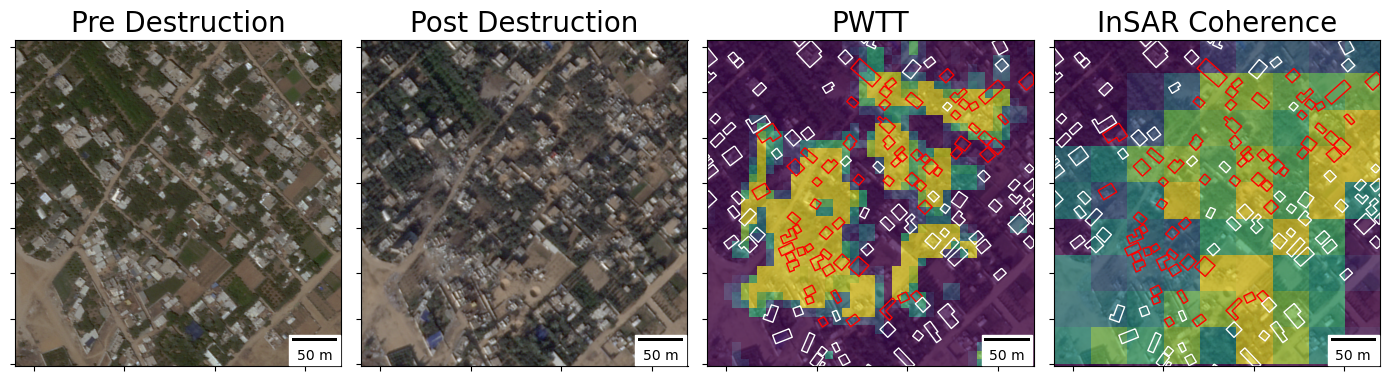

In [8]:
import numpy as np
def plot_row(pt,window):
    skysat_dir='../data/Gaza/skysat/'
    folders=os.listdir(skysat_dir)
    nov_tifs=[tif for tif in glob.glob(f'{skysat_dir}2023_11/*.tif')]
    pre_tifs=[tif for tif in glob.glob(f'{skysat_dir}pre_war/*.tif')]

    #unosat=gpd.read_file('../data/Gaza/UNOSAT/UNOSAT_GAZA_20231107.shp')
    unosat=gpd.read_file('../data/Gaza/Gaza_20231107_2_footprints.csv')
    unosat['geometry']=unosat['.geo'].apply(lambda x: shapely.geometry.shape(json.loads(x)))
    unosat=gpd.GeoDataFrame(unosat, geometry='geometry', crs='EPSG:4326')

    insar='../data/insar/clean/Gaza_20231001.tif'
    #insar='../data/insar/clean/Gaza_20230930.tif'

    pwtt='../data/Gaza/Gaza_20231107_2_raster.tif'
    #pwtt='../data/Gaza/Gaza_20231126_2_raster.tif'

    #fig, ax = plt.subplots(1,4, figsize=(5, 10))
    fig, ax = plt.subplots(1,4, figsize=(14, 4))

    insar=buffer_crop(insar,pt,window)
    pwtt=reproj(pwtt,'epsg:32636')
    pwtt=buffer_crop(pwtt,pt,window)
    unosat=unosat.to_crs(pwtt.crs)

    pre_tifs=find_tifs(pt, pre_tifs)
    post_tifs=find_tifs(pt, nov_tifs)
    
#    pre=buffer_crop(pre_tifs[0], pt, window)
#    post=buffer_crop(post_tifs[1], pt, window)

    pre=buffer_crop(pre_tifs[1], pt, window)
    post=buffer_crop(post_tifs[7], pt, window)

    xmin, ymin, xmax, ymax = pre.bounds
    #unosat=unosat.cx[xmin:xmax, ymin:ymax]
    unosat=unosat.clip(box(xmin, ymin, xmax, ymax))
    damaged=unosat[unosat['class']=='1']
    undamaged=unosat[unosat['class']=='0']

    pre_rgb=hist_match(pre.read([1,2,3]), post.read([1,2,3])).astype(np.uint8)
    
    show(pre_rgb,transform=pre.transform, ax=ax[0])
    #unosat.plot(ax=ax[0], color='red', alpha=0.6,markersize=10)

    show(post.read([1,2,3]),transform=post.transform, ax=ax[1])
    #unosat.plot(ax=ax[1], color='red', alpha=0.6,markersize=10)

    show(post.read([1,2,3]),transform=post.transform, ax=ax[2])
    show(pwtt.read([1]).mean(axis=0), transform=pwtt.transform, vmin=3,vmax=5, alpha=.6, ax=ax[2])
    #unosat.plot(ax=ax[2], column='class',markersize=10, alpha=0.8, cmap='RdGy_r')
    lw=1
    line_alpha=1
    damaged.plot(ax=ax[2], edgecolor='red', facecolor='none', alpha=line_alpha,lw=lw)
    undamaged.plot(ax=ax[2], edgecolor='white', facecolor='none', alpha=line_alpha, lw=lw)

    #cx.add_basemap(ax=ax, crs=insar.crs.to_string(), source=cx.providers.MapBox(accessToken=mapbox_token, url='https://api.mapbox.com/styles/v1/oballinger/clq3pnfvc00ct01pl7af9hyy7/tiles/{z}/{x}/{y}{r}?access_token={accessToken}'), alpha=1, attribution='Mapbox')
    show(post.read([1,2,3]),transform=post.transform, ax=ax[3])
    show(insar.read(1)*-1, vmin=0.4,vmax=.8, alpha=.6, transform=insar.transform, ax=ax[3])
    damaged.plot(ax=ax[3], edgecolor='red', facecolor='none', alpha=line_alpha,lw=lw)
    undamaged.plot(ax=ax[3], edgecolor='white', facecolor='none', alpha=line_alpha,lw=lw)

    #unosat.plot(ax=ax[3], color='red', alpha=0.6,markersize=7)
    #unosat.plot(ax=ax[3], column='class',markersize=10, alpha=0.8, cmap='RdGy_r')

    titles=['Pre Destruction', 'Post Destruction', 'PWTT','InSAR Coherence']

    for a in ax:
        scalebar = ScaleBar(1, units='m', location='lower right')
        #force axis extent
        a.set_xlim(xmin, xmax)
        a.set_ylim(ymin, ymax)
        #a.axis('off')
        # remove axis ticklabels 
        a.set_xticklabels([])
        a.set_yticklabels([])
        #increase fontsize for title 
        a.set_title(titles.pop(0), fontsize=20)
        a.add_artist(scalebar)

    plt.tight_layout()
    plt.savefig('../figs/pwtt_coh_comparison2.png', dpi=300)
    plt.show()


beit_hanoun=convert_coords(34.522359,31.546570, 'epsg:4326','epsg:32636')
central_gaza=convert_coords(34.40163,31.43744, 'epsg:4326','epsg:32636')
nw_gaza=Point(633289.384,3482754.016)
low_density=Point(633359.34,3481677.71)

pt=beit_hanoun
window=380
pt=move_pt(pt, 100, 200)

windows=range(100, 500, 20)
# for window in windows:
#     print(window)
#     plot_row(pt, window)
#plot_row(pt, 300)
plot_row(low_density, 180)